In [204]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [206]:
# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Định nghĩa transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize ảnh về 128x128
    transforms.ToTensor(),  # Chuyển thành tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa
])

# Đường dẫn đến thư mục train và test
data_dir = "Dataset"  # Thay bằng đường dẫn đúng
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")

# Load dữ liệu
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Using device: cpu


In [208]:
# Định nghĩa mô hình CNN
class AppleCNN(nn.Module):
    def __init__(self):
        super(AppleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 lớp đầu ra

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [210]:
# Khởi tạo mô hình, loss function và optimizer
model = AppleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
num_epochs = 10
loss_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 1.2305
Epoch 2/10, Loss: 0.7095
Epoch 3/10, Loss: 0.5372
Epoch 4/10, Loss: 0.3767
Epoch 5/10, Loss: 0.2798
Epoch 6/10, Loss: 0.1370
Epoch 7/10, Loss: 0.0690
Epoch 8/10, Loss: 0.0524
Epoch 9/10, Loss: 0.0411
Epoch 10/10, Loss: 0.0220


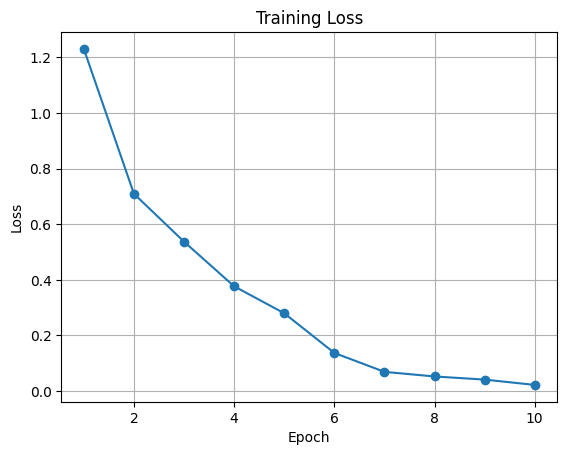

In [212]:
# Vẽ biểu đồ loss
plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()


In [214]:
# Đánh giá mô hình
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 97.94%


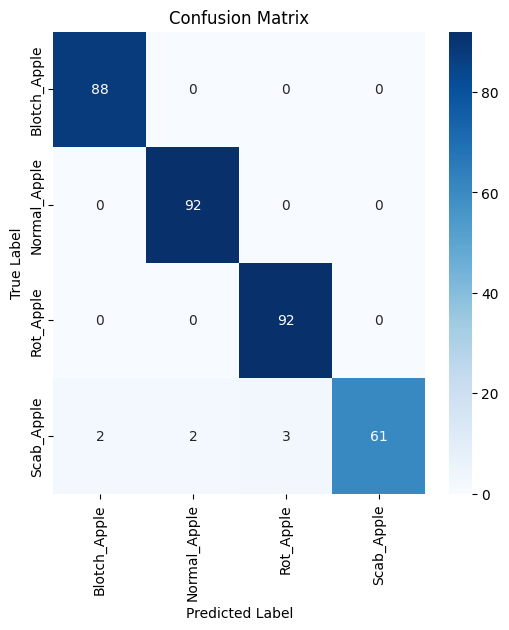

              precision    recall  f1-score   support

Blotch_Apple       0.98      1.00      0.99        88
Normal_Apple       0.98      1.00      0.99        92
   Rot_Apple       0.97      1.00      0.98        92
  Scab_Apple       1.00      0.90      0.95        68

    accuracy                           0.98       340
   macro avg       0.98      0.97      0.98       340
weighted avg       0.98      0.98      0.98       340



In [216]:
# Lưu giá trị thực tế và dự đoán
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = train_dataset.classes  # Lấy tên class từ dataset
# Vẽ confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# In báo cáo phân loại
print(classification_report(y_true, y_pred, target_names=class_names))

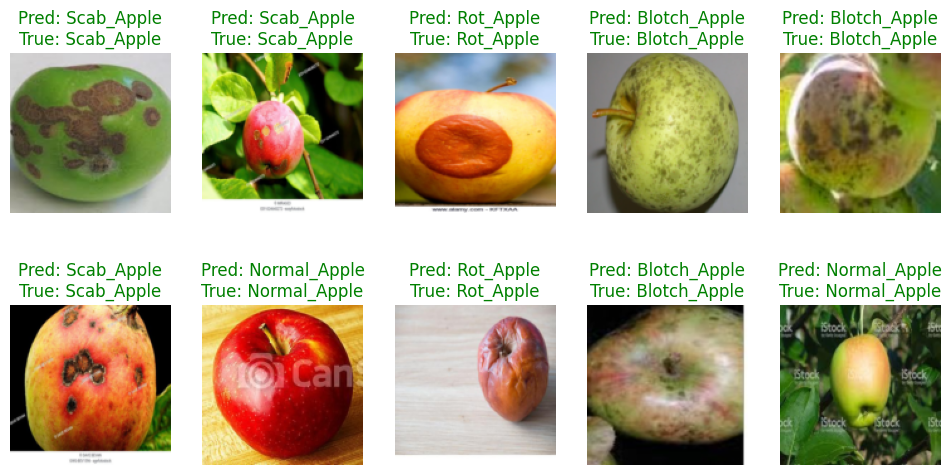

In [218]:
import random

# Chọn ngẫu nhiên 10 ảnh từ tập test
num_images = 10
indices = random.sample(range(len(test_dataset)), num_images)

# Load ảnh và hiển thị dự đoán
plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    image, label = test_dataset[idx]  # Lấy ảnh từ dataset
    image_input = image.unsqueeze(0).to(device)  # Thêm batch dimension
    output = model(image_input)  # Dự đoán
    _, predicted_label = torch.max(output, 1)
    
    # Chuyển ảnh về dạng có thể hiển thị
    image = image.permute(1, 2, 0).numpy()
    image = (image * 0.5) + 0.5  # Unnormalize

    # Hiển thị ảnh
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {class_names[predicted_label.item()]}\nTrue: {class_names[label]}", 
              color="green" if predicted_label.item() == label else "red")

plt.show()


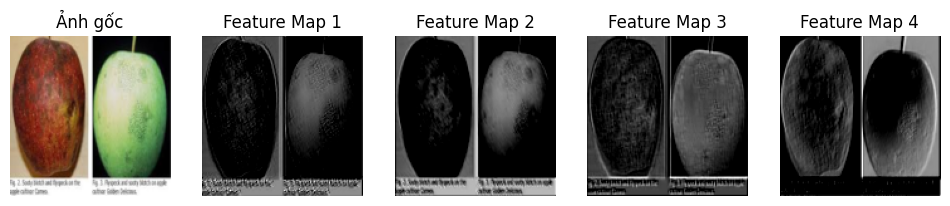

In [232]:
def visualize_feature_map():
    model.eval()  # Chuyển sang chế độ đánh giá
    images, _ = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra
    img = images[0].unsqueeze(0).to(device)  # Lấy ảnh đầu tiên, thêm chiều batch (1x3x64x64)

    # Tính feature map từ conv1
    with torch.no_grad():
        conv1_output = torch.relu(model.conv1(img))  # Qua conv1 và ReLU

    # Chuyển ảnh gốc từ [-1,1] về [0,1] (nếu cần)
    img_show = img.cpu().squeeze().permute(1, 2, 0).numpy()  # Chuyển về (H, W, C)
    img_show = (img_show + 1) / 2  # Chuyển từ [-1,1] về [0,1]

    # Vẽ ảnh gốc
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 5, 1)
    plt.title("Ảnh gốc")
    plt.imshow(img_show)  # Không còn lỗi về range
    plt.axis('off')

    # Vẽ một số feature maps từ conv1
    for i in range(4):  # Hiển thị 4 feature maps đầu tiên
        plt.subplot(1, 5, i + 2)
        plt.title(f"Feature Map {i+1}")
        feature_map = conv1_output[0, i].cpu().numpy()

        # Chuẩn hóa feature map về [0,1]
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

        plt.imshow(feature_map, cmap='gray')
        plt.axis('off')

    plt.show()

visualize_feature_map()

In [11]:
import torch
import torch.nn as nn

# Define a simple CNN with a single 3x3 convolutional layer
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)

# Get the weights of the convolutional layer
kernel_weights = conv_layer.weight.data
print(kernel_weights)

tensor([[[[ 0.3281,  0.2547,  0.0640],
          [ 0.0870,  0.1564, -0.1748],
          [ 0.1825,  0.1982,  0.1031]]]])
